In [1]:
#Scikit-Learn 1.1.1
import sklearn
assert sklearn.__version__ >= '1.1'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from time import time
from sklearn.decomposition import PCA

## 1) Load Data

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4, funneled=False)

In [4]:
#check some basic features about the data, and visualize it
print(f"- Images shape: {faces.images.shape}")
print(f"- Data (flattened images) shape: {faces.data.shape}")
print(f"- Target shape: {faces.target.shape}")
print(f"- Number of classes: {np.unique(faces.target).shape}")
print(f"- Each class is a famous person: {', '.join(faces.target_names)}")

- Images shape: (1288, 50, 37)
- Data (flattened images) shape: (1288, 1850)
- Target shape: (1288,)
- Number of classes: (7,)
- Each class is a famous person: Ariel Sharon, Colin Powell, Donald Rumsfeld, George W Bush, Gerhard Schroeder, Hugo Chavez, Tony Blair


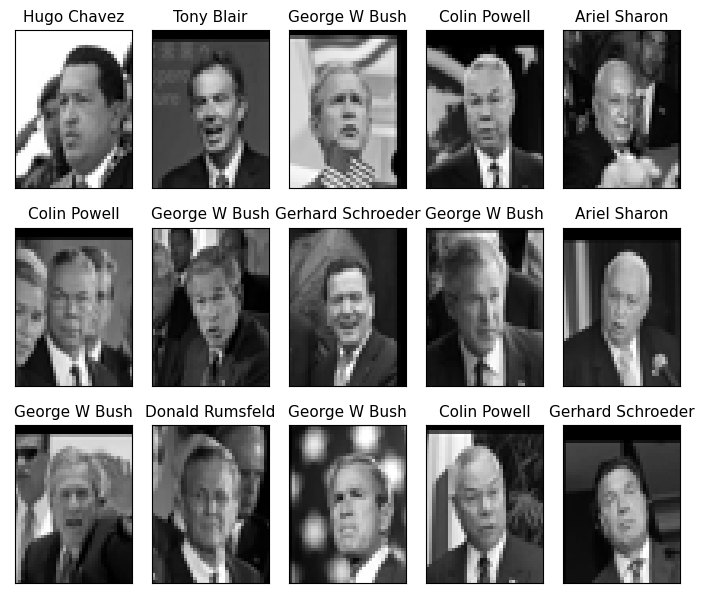

In [5]:
fig = plt.figure(figsize=(7,10))

for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

plt.tight_layout()

## 2) Compression with PCA

We have **1288** observations (images) and **1850** features (50 × 37 pixels)  

We know that so many features for so little observations is not great in Machine Learning  
(Rule of thumb, at least: $n_{features} << \sqrt{n_{observations}}$ )

**PCA** can help reduce these features to a more manageable size while maintaining most of the information in the data

In [6]:
#Fitting a `PCA` on flattened images to reduce their dimensions to 150 components  
pca = PCA(n_components=150)
pca.fit(faces.data)

PCA(n_components=150)

In [7]:
faces.data.shape

(1288, 1850)

In [8]:
data_projected = pca.fit_transform(faces.data)
data_projected.shape

(1288, 150)

Now, we don't need 1850 pixels anymore to describe each images but only 150 values! (A gain by factor of 12)

In [9]:
pca.components_.shape

(150, 1850)

We now have 150 components (vectors) of 1850 values each.
One face is described as a linear combination of those components.
Let's reconstruct one image from its reduced representation to see how it works.

In [10]:
data_reconstructed = pca.inverse_transform(data_projected)
data_reconstructed.shape

(1288, 1850)

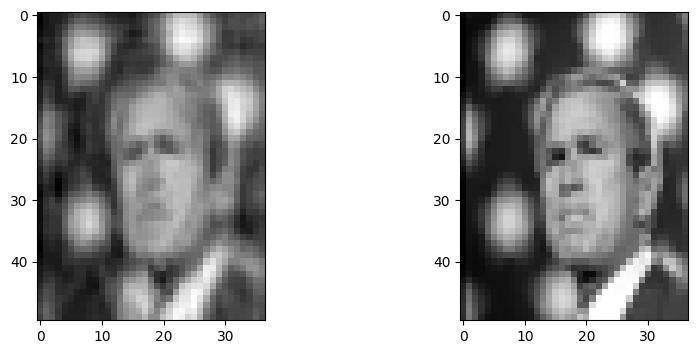

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(data_reconstructed[12].reshape((50, 37)), cmap=plt.cm.gray)
axs[1].imshow(faces.images[12], cmap=plt.cm.gray);
#on the left in the reconstructed image, on the right is the original one

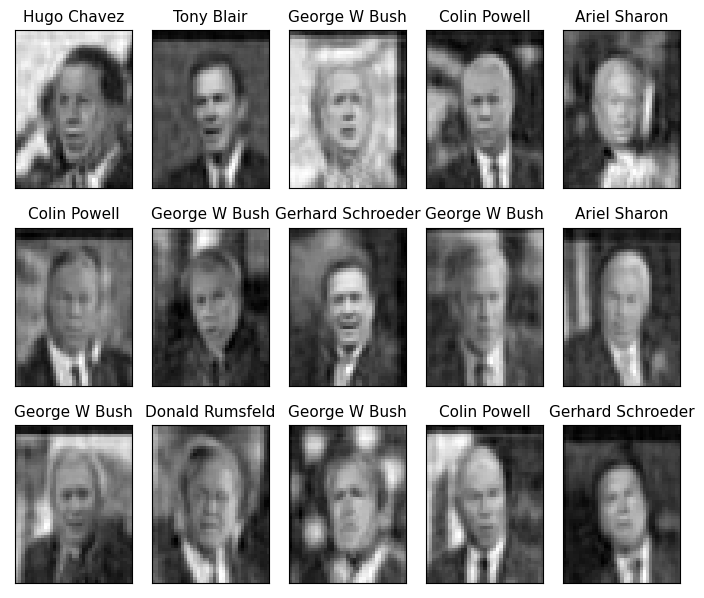

In [12]:
fig = plt.figure(figsize=(7,10))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=11)
    plt.imshow(pca.inverse_transform(data_projected)[i].reshape((50,37)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())
    
plt.tight_layout()

## 3) Investigate Principal Components

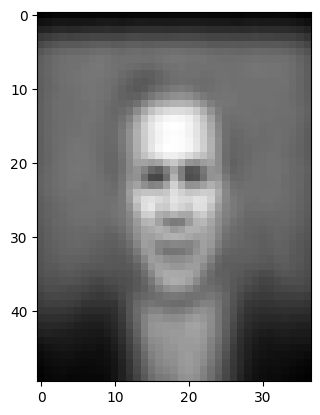

In [13]:
plt.imshow(pca.mean_.reshape((50,37)), cmap='gray');
#this face supposedly is the "mean face" of the dataset

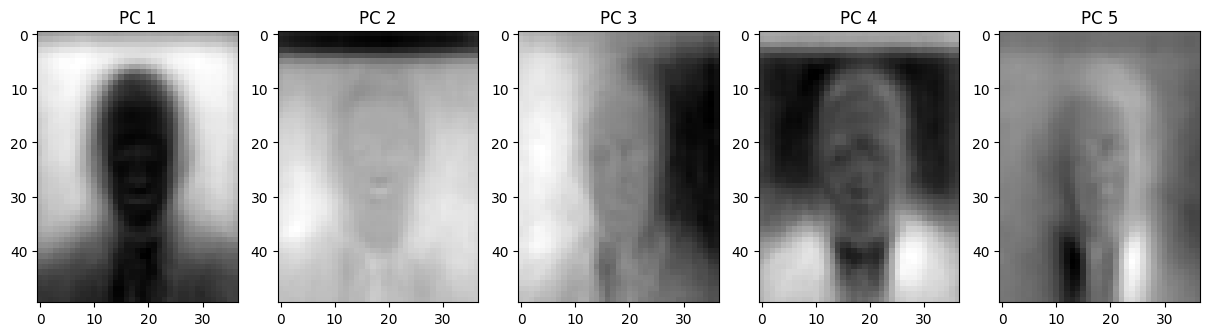

In [14]:
fig = plt.figure(figsize=(15,20))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.title(f'PC {i+1}', size=12)
    plt.imshow(pca.components_[i].reshape(50,37), cmap='gray')
#These images correspond to the first 5 principal components

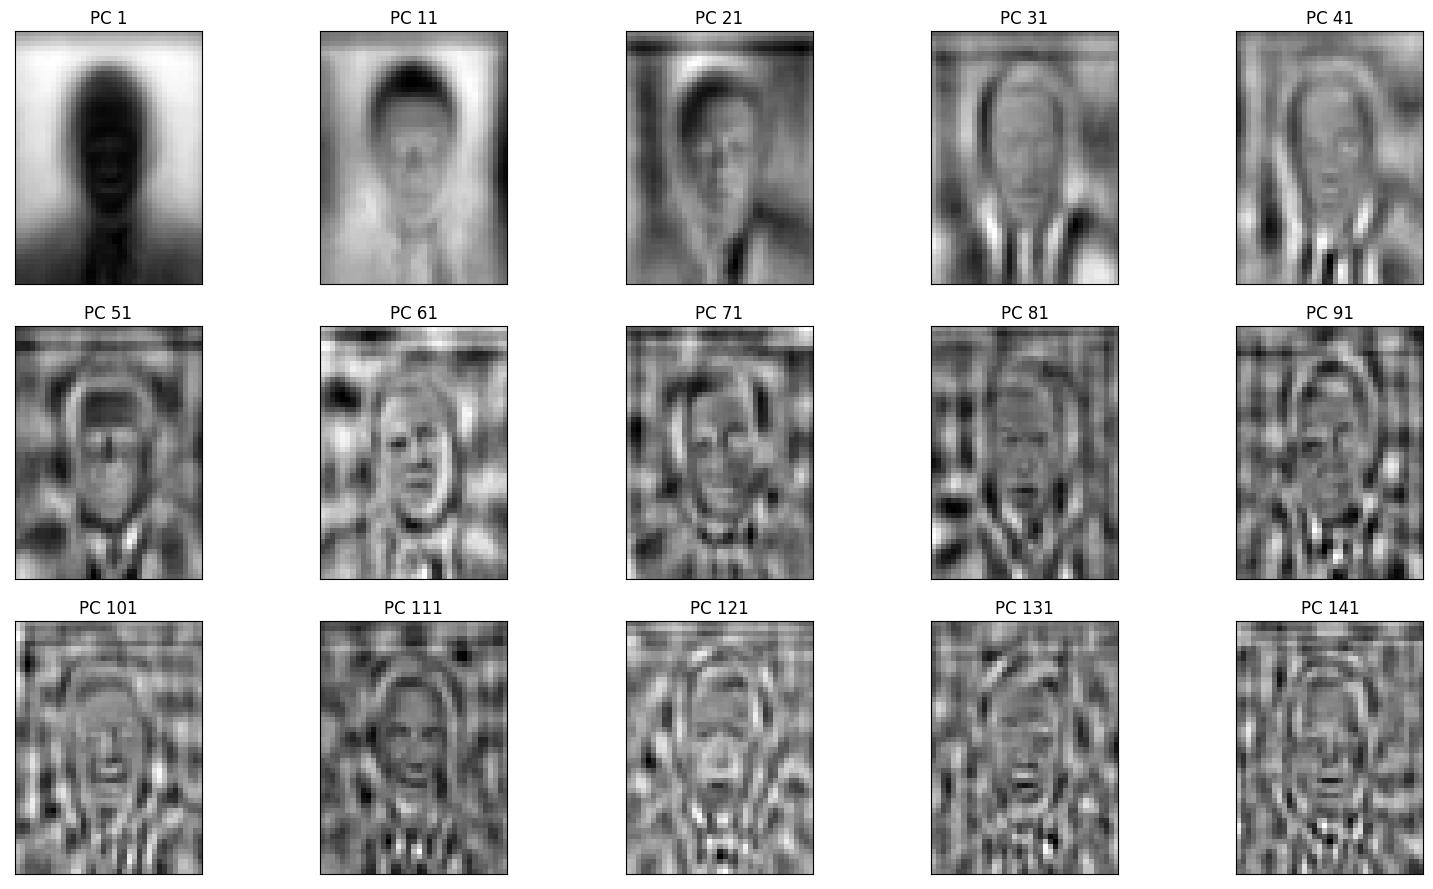

In [15]:
#plotting several images corresponding to principal components
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'PC {i * 10 + 1}', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(pca.components_[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()

## 4) Choose the Optimal Number of Components

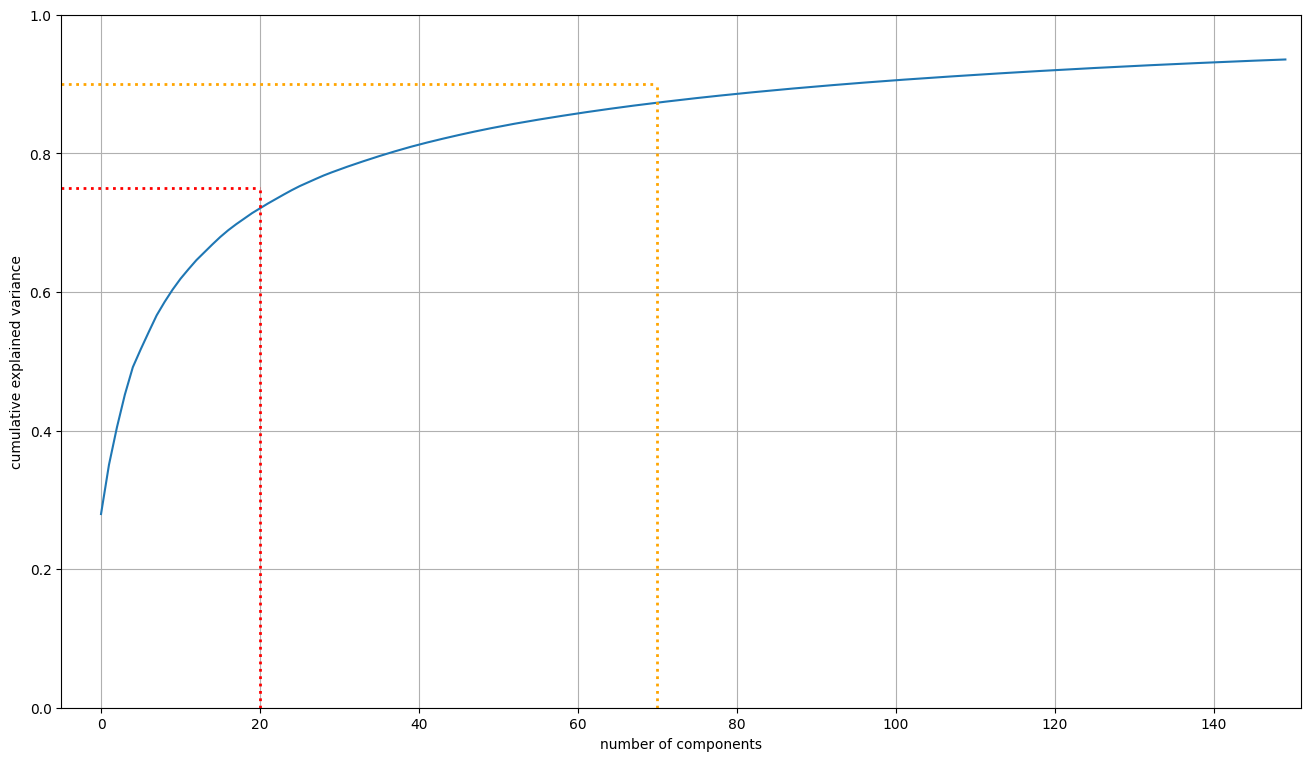

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()
plt.xlim((-5, 151))
plt.ylim((0, 1))
plt.hlines(y=[.75, .9], xmin=[-5, -5], xmax=[20, 70],
           linestyles='dotted', colors=['red', 'orange'], linewidth=2)
plt.vlines(x=[20, 70], ymin=[0, 0], ymax=[.75, .9],
           linestyles='dotted', colors=['red', 'orange'], linewidth=2);

In [17]:
minimal_pc_count=38 #to keep at least 80% of the variance

## 5) Classify images (PCA as feature engineering)


Given a a picture of a face of a famous person among a selection, a person should be able tell whom the face belongs to,
Our samples are images
Our features are their pixels
Our target is one class among several the 7 (a name of a person)

In [18]:
X = faces.data
y = faces.target

In [19]:
start = time()
cvs = cross_validate(SVC(class_weight="balanced"), X, y, cv=5, scoring='accuracy')
duration = time() - start 

score_original = cvs['test_score'].mean()
time_original = duration

round(score_original, 3), round(time_original, 3)

(0.575, 12.68)

In [20]:
#we do the same but this time instead we use projections as images
start = time()
cvs = cross_validate(SVC(class_weight="balanced"), data_projected, y, cv=5, scoring='accuracy')
duration = time() - start 

score_reduced = cvs['test_score'].mean()
time_reduced = duration

round(score_reduced, 3), round(time_reduced, 3)

(0.568, 1.529)

The quality of our model has slightly decreased   
However the time needed to train and evaluate the model has *greatly* decreased 

## 6) Search for the Optimal Number of Components

*performing a Grid Search*

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
#a grid search calls for a pipeline
pipe = make_pipeline(PCA(random_state=42), SVC()) # random_state added for reproducibility purposes
pipe.get_params()                                 # the solver of PCA introduces some randomness

{'memory': None,
 'steps': [('pca', PCA(random_state=42)), ('svc', SVC())],
 'verbose': False,
 'pca': PCA(random_state=42),
 'svc': SVC(),
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': 42,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [23]:
param_grid = {"pca__n_components": [50, 100, 200, 300]}

clf = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

In [24]:
clf = clf.fit(X_train, y_train)

In [25]:
y_pred = clf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.50      0.58        18
           1       0.73      0.54      0.62        69
           2       1.00      0.09      0.16        34
           3       0.51      0.98      0.67       166
           4       1.00      0.03      0.06        31
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        50

    accuracy                           0.55       387
   macro avg       0.56      0.31      0.30       387
weighted avg       0.55      0.55      0.44       387



/home/margot95/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/margot95/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/margot95/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [26]:
best_n_components = clf.best_estimator_.get_params()['pca__n_components']
best_n_components

200

## Scaling, Balancing and Tuning

In [27]:
baseline = pd.Series(y).value_counts(normalize=True).max()

score_base = cross_validate(make_pipeline(PCA(n_components=best_n_components),
                                             SVC()),
                               X, y,
                               scoring='accuracy',
                               cv=3,
                               n_jobs=-1)['test_score'].mean()


print(f"""Accuracy scores:
Baseline (frequency of most frequent class): {baseline: .2%}
Base Model (PCA + SVC): {score_base:.2%}""")

Accuracy scores:
Baseline (frequency of most frequent class):  41.15%
Base Model (PCA + SVC): 52.10%


### Scaling

In [28]:
pipe_scaling = make_pipeline(StandardScaler(), PCA(n_components=best_n_components), SVC())

In [29]:
score_scaling = cross_validate(
    pipe_scaling,
    X, y,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)['test_score'].mean()

round(score_scaling, 3)

0.627

### Balancing

In [30]:
#checking the repartition of our target classes
pd.Series(y).value_counts(normalize=True)

3    0.411491
1    0.183230
6    0.111801
2    0.093944
4    0.084627
0    0.059783
5    0.055124
dtype: float64

In [31]:
#it's highly umbalanced, this will cause our model to predict the most represented class

In [32]:
pipe_balanced = make_pipeline(
    StandardScaler(),
    PCA(n_components=best_n_components),
    SVC(class_weight='balanced')
)

In [33]:
score_balanced = cross_validate(pipe_balanced, X, y, scoring='accuracy', cv=3, n_jobs=-1)['test_score'].mean()

round(score_balanced, 3)

0.651

### Fine-tuning

Let's find the combination of hyperparameters that yields the highest score

In [34]:
pipe_balanced._final_estimator.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [35]:
grid = {
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],
    'svc__gamma': [1e-4, 1e-3, 1e-2],
    'svc__C': [10, 1e2, 1e3]
}

search = GridSearchCV(
    pipe_balanced, 
    grid,
    cv=3,
    scoring='accuracy'
)

search.fit(X, y)
score_tuned = search.best_score_
round(score_tuned, 5)

0.75774

## Reconstruction of an original image

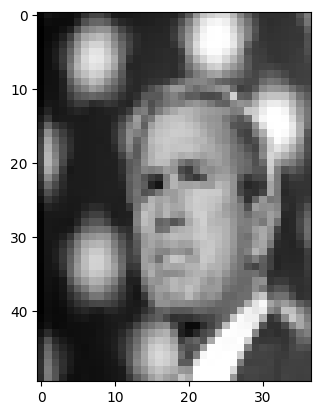

In [36]:
# We do our reconstruction over the 13th image
image_original = faces.images[12];
image_compressed = data_projected[12];

plt.imshow(image_original, cmap='gray');

Let's manually do the sum of multiplications $X\_reconstructed_{i} = \sum_{i=1}^{n\_components}{X_{projected_i} * W_i}$  
$W_i$ being the `i-th principal component`  

In [37]:
# we start the reconstruction from the mean over all images
image_reconstructed = pca.mean_.copy(); 

# Then, we reconstruct the image by doing the sum of every 150 entry of its compressed representation, weighted by the corresponding principal components

reconstruction = list()
for i in range(pca.n_components_):
    image_reconstructed += pca.components_[i] * image_compressed[i]
    reconstruction.append(image_reconstructed.copy())

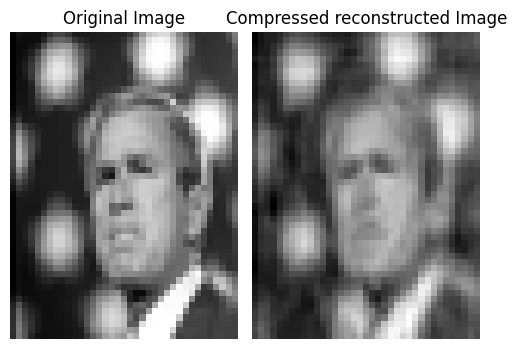

In [38]:
# Plotting the original and the compressed image
fig, ax = plt.subplots(1, 2, figsize = (5,5))
ax[0].imshow(image_original, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_reconstructed.reshape(faces.images[0].shape), cmap='gray')
ax[1].set_title('Compressed reconstructed Image')
for ax in fig.axes:
    ax.axis('off')
plt.tight_layout()

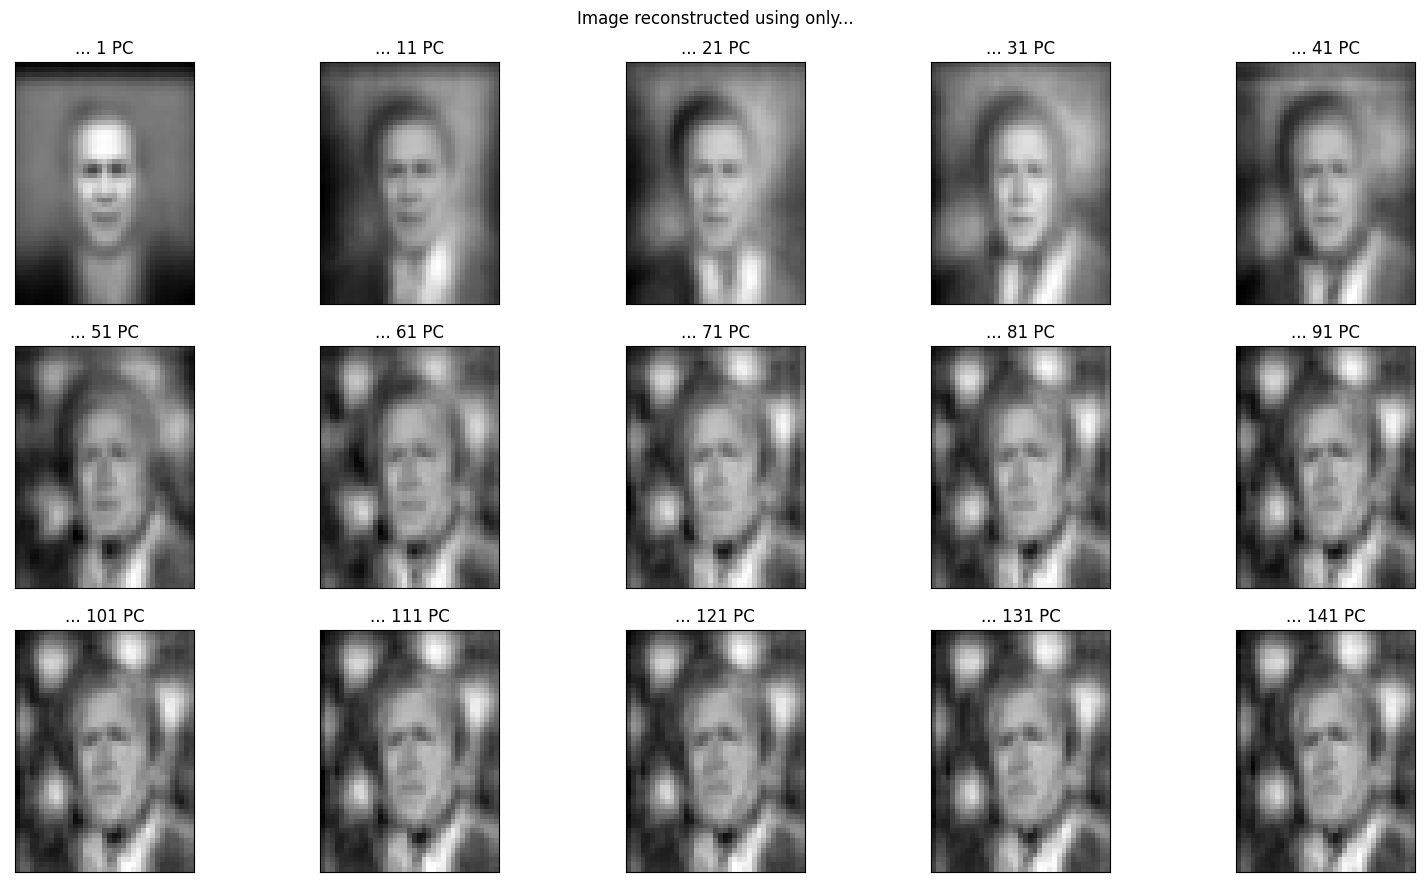

In [39]:
# Plotting several images at different steps of reconstruction
n_rows, n_cols = 3, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 9))
plt.suptitle('Image reconstructed using only...')

for i in range(n_rows * n_cols):
    ax = axs[i // n_cols, i % n_cols]
    ax.set_title(f'... {i * 10 + 1} PC', size=12)
    ax.set_xticks(()), ax.set_yticks(())
    ax.imshow(reconstruction[i * 10].reshape(50, 37), cmap='gray')

plt.tight_layout()